#Imports

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pylab as plt

import pandas as pd
import os, re, json, functools
import re
import bz2

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [2]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
os.environ['KAGGLE_USERNAME'] = "diegorivera"
os.environ['KAGGLE_KEY'] = "aa64ec7b061f7ee50f4e98b16ed8cd77"

In [4]:
#https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset
#!kaggle datasets download -d stefanoleone992/fifa-20-complete-player-dataset
!kaggle datasets download -d bittlingmayer/amazonreviews

100% 491M/493M [00:02<00:00, 180MB/s]
100% 493M/493M [00:02<00:00, 183MB/s]


In [5]:
!unzip -o amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


#Dataset

READING TEXT

In [0]:
def splitReviewsLabels(lines):
    reviews = []
    labels = []
    for review in tqdm(lines):
        rev = reviewToX(review)
        label = reviewToY(review)
        reviews.append(rev[:512])
        labels.append(label)
    return reviews, labels

In [0]:
def reviewToY(review):
    return [1,0] if review.split(' ')[0] == '__label__1' else [0,1]

In [0]:
def reviewToX(review):
    review = review.split(' ', 1)[1][:-1].lower()
    review = re.sub('\d','0',review)
    if 'www.' in review or 'http:' in review or 'https:' in review or '.com' in review:
        review = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", review)
    return review

In [0]:
train_file = bz2.BZ2File('/content/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/test.ft.txt.bz2')

In [0]:
train_lines = train_file.readlines()
test_lines = test_file.readlines()

In [0]:
train_lines = [x.decode('utf-8') for x in train_lines]
test_lines = [x.decode('utf-8') for x in test_lines]

In [12]:
reviews_train, y_train = splitReviewsLabels(train_lines)
reviews_test, y_test = splitReviewsLabels(test_lines)

100%|██████████| 400000/400000 [00:06<00:00, 62122.74it/s]


In [0]:
reviews_train, y_train = shuffle(reviews_train, y_train)
reviews_test, y_test = shuffle(reviews_test, y_test)

In [0]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
max_features = 8192
maxlen = 128
embed_size = 64

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(reviews_train)

In [0]:
token_train = tokenizer.texts_to_sequences(reviews_train)
token_test = tokenizer.texts_to_sequences(reviews_test)

In [0]:
x_train = pad_sequences(token_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(token_test, maxlen=maxlen, padding='post')

#Model

In [0]:
EPOCHS = 5
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 16

In [0]:
def train(model, epochs=EPOCHS):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model.fit(x_train, y_train, epochs=epochs,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=(x_test, y_test),
                      validation_steps=VALIDATION_STEPS
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

##Bidirectional LSTM

In [22]:
model = Sequential([
    Embedding(max_features, embed_size),
    Bidirectional(LSTM(64)),
    Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          524288    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = train(model)
plot_accuracy_and_loss(history)

Train on 3600000 samples, validate on 400000 samples
Epoch 1/5


##Stack LSTM

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.summary()

NameError: ignored

Train for 32 steps, validate for 16 steps
Epoch 1/5
32/32 [==============================] - 267s 8s/step - loss: 0.6924 - accuracy: 0.5273 - val_loss: 0.6881 - val_accuracy: 0.5811
Epoch 2/5
32/32 [==============================] - 229s 7s/step - loss: 0.6229 - accuracy: 0.6621 - val_loss: 0.5586 - val_accuracy: 0.7178
Epoch 3/5
32/32 [==============================] - 225s 7s/step - loss: 0.4797 - accuracy: 0.7671 - val_loss: 0.5450 - val_accuracy: 0.7109
Epoch 4/5
32/32 [==============================] - 231s 7s/step - loss: 0.4287 - accuracy: 0.8101 - val_loss: 0.6188 - val_accuracy: 0.7568
Epoch 5/5
32/32 [==============================] - 230s 7s/step - loss: 0.4772 - accuracy: 0.7998 - val_loss: 0.4641 - val_accuracy: 0.7861


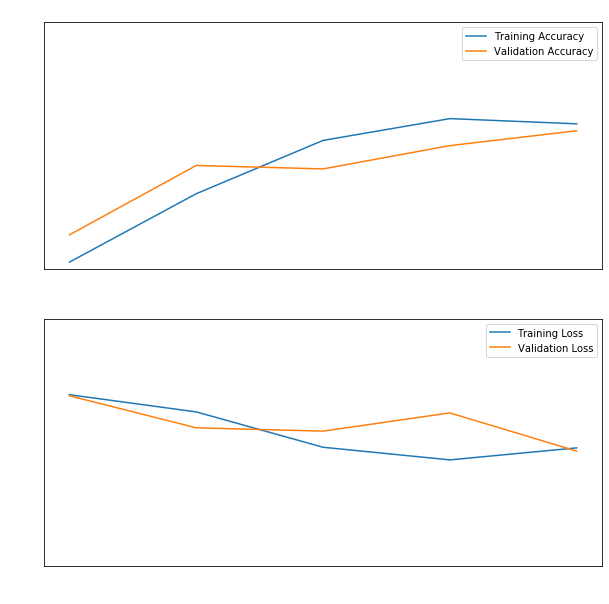

In [0]:
history = train(model)
plot_accuracy_and_loss(history)

##ConvNet

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

In [0]:
history = train(model, epochs=10)
plot_accuracy_and_loss(history)

##GRU

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model)
plot_accuracy_and_loss(history)

NameError: ignored

In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Conv1D(32, 3, padding='same', activation = 'relu'),
    MaxPooling1D(2),
    Bidirectional(GRU(64)),
    Dense(1, activation='sigmoid')
])

model.summary()

history = train(model, epochs=10)
plot_accuracy_and_loss(history)

